In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
df = pd.read_csv('/content/GOOG_with_Tomorrow_Close_Final.csv')

In [ ]:
df.head()

,Date,Close,High,Low,Open,Volume,Daily_Sentiment,tomorrow's closing value
0,2008-06-09,13.812565,14.112898,13.503815,14.064865,212324874,0.026156,13.720956
1,2008-06-10,13.720956,13.836088,13.537983,13.606814,146844353,-0.029106,13.498861
2,2008-06-11,13.498861,13.799442,13.480540,13.772207,153087667,-0.014500,13.690750
3,2008-06-12,13.690750,13.815785,13.540459,13.587008,220487355,0.036611,14.150284
4,2008-06-13,14.150284,14.254026,13.898480,13.902193,248303226,0.069818,14.182473


In [ ]:
def calculate_rsi(data, period=14):
        delta = data['Close'].diff()  # Calculate the difference between consecutive close prices
        gain = delta.where(delta > 0, 0)  # Gain is positive delta
        loss = -delta.where(delta < 0, 0)  # Loss is negative delta (converted to positive)

        # Calculate the average gain and average loss
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()

        # Avoid division by zero
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))  # RSI formula

        return rsi

In [ ]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create simple moving average
    data['SMA_14'] = data['Close'].rolling(window=14).mean()

    # Create RSI
    data['RSI_14'] = calculate_rsi(data, period=14)

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
tech_df = get_tech_ind(df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)

# print(dataset.shape)
# dataset.to_csv('Final_dataset_tesla.csv', index= False)
dataset.head()

,Date,Close,High,Low,Open,Volume,Daily_Sentiment,tomorrow's closing value,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,SMA_14,RSI_14,logmomentum
0,2008-07-08,13.729869,13.746210,13.370114,13.518422,198035514,0.044273,13.408491,13.212396,13.556701,0.041305,0.348524,14.253749,12.859652,13.457881,13.419703,42.817318,2.527201
1,2008-07-09,13.408491,13.758343,13.388188,13.636526,166782808,-0.023143,13.384227,13.294032,13.558187,0.059555,0.348812,14.255811,12.860562,13.576978,13.382865,40.517200,2.536591
2,2008-07-10,13.384227,13.605329,13.140347,13.493912,173917451,0.018000,13.216604,13.338351,13.544272,0.066723,0.345359,14.234990,12.853554,13.521601,13.348149,40.964770,2.525241
3,2008-07-11,13.216604,13.357733,12.860811,13.283455,200002860,0.006788,12.915035,13.398198,13.529094,0.080107,0.350021,14.229136,12.829053,13.362837,13.325812,43.786287,2.508253
4,2008-07-14,12.915035,13.371599,12.762269,13.345354,177655409,0.068159,12.778114,13.407005,13.501252,0.142244,0.340806,14.182865,12.819640,13.351182,13.284092,39.523969,2.513280


In [ ]:
df = dataset.drop([ 'Date'], axis =1)
df.head()

,Close,High,Low,Open,Volume,Daily_Sentiment,tomorrow's closing value,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,SMA_14,RSI_14,logmomentum
0,13.729869,13.746210,13.370114,13.518422,198035514,0.044273,13.408491,13.212396,13.556701,0.041305,0.348524,14.253749,12.859652,13.457881,13.419703,42.817318,2.527201
1,13.408491,13.758343,13.388188,13.636526,166782808,-0.023143,13.384227,13.294032,13.558187,0.059555,0.348812,14.255811,12.860562,13.576978,13.382865,40.517200,2.536591
2,13.384227,13.605329,13.140347,13.493912,173917451,0.018000,13.216604,13.338351,13.544272,0.066723,0.345359,14.234990,12.853554,13.521601,13.348149,40.964770,2.525241
3,13.216604,13.357733,12.860811,13.283455,200002860,0.006788,12.915035,13.398198,13.529094,0.080107,0.350021,14.229136,12.829053,13.362837,13.325812,43.786287,2.508253
4,12.915035,13.371599,12.762269,13.345354,177655409,0.068159,12.778114,13.407005,13.501252,0.142244,0.340806,14.182865,12.819640,13.351182,13.284092,39.523969,2.513280


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Close                     2011 non-null   float64
 1   High                      2011 non-null   float64
 2   Low                       2011 non-null   float64
 3   Open                      2011 non-null   float64
 4   Volume                    2011 non-null   int64  
 5   Daily_Sentiment           2011 non-null   float64
 6   tomorrow's closing value  2011 non-null   float64
 7   MA7                       2011 non-null   float64
 8   MA20                      2011 non-null   float64
 9   MACD                      2011 non-null   float64
 10  20SD                      2011 non-null   float64
 11  upper_band                2011 non-null   float64
 12  lower_band                2011 non-null   float64
 13  EMA                       2011 non-null   float64
 14  SMA_14  

In [ ]:
df[df.isnull().any(axis=1)]

,Close,High,Low,Open,Volume,Daily_Sentiment,tomorrow's closing value,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,SMA_14,RSI_14,logmomentum


In [ ]:
df = df.dropna()
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Close                     2011 non-null   float64
 1   High                      2011 non-null   float64
 2   Low                       2011 non-null   float64
 3   Open                      2011 non-null   float64
 4   Volume                    2011 non-null   int64  
 5   Daily_Sentiment           2011 non-null   float64
 6   tomorrow's closing value  2011 non-null   float64
 7   MA7                       2011 non-null   float64
 8   MA20                      2011 non-null   float64
 9   MACD                      2011 non-null   float64
 10  20SD                      2011 non-null   float64
 11  upper_band                2011 non-null   float64
 12  lower_band                2011 non-null   float64
 13  EMA                       2011 non-null   float64
 14  SMA_14  

,Close,High,Low,Open,Volume,Daily_Sentiment,tomorrow's closing value,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,SMA_14,RSI_14,logmomentum
2006,33.561504,34.266314,33.473526,33.559017,88980000,0.045548,33.215561,34.739290,35.557392,0.430170,0.746181,37.049753,34.065030,33.938586,35.200584,26.244378,3.483054
2007,33.215561,33.416371,32.968233,33.351752,52580000,0.003085,33.801079,34.427500,35.425649,0.541665,0.885926,37.197502,33.653797,33.547364,35.028784,24.219544,3.476668
2008,33.801079,33.815493,33.451161,33.747898,43476000,0.035911,34.003376,34.216754,35.294504,0.563662,0.931608,37.157720,33.431288,33.681053,34.857516,24.340380,3.488839
2009,34.003376,34.168342,33.869172,33.948204,38652000,0.038622,34.400517,34.104776,35.166440,0.557582,0.931844,37.030127,33.302753,33.859154,34.699633,27.257855,3.494937
2010,34.400517,34.411453,33.980512,34.070974,31954000,0.022841,34.003376,34.012964,35.049559,0.493831,0.914279,36.878118,33.221001,34.000367,34.602673,35.862893,3.498656


# LSTM Model result with primary features

In [ ]:
features = df[['Open','High','Low','Volume', 'Close']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
# # Initialize the scaler
# scaler = StandardScaler()

# # Fit on training data and transform both training and test features
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)  # Use transform on test data to avoid data leakage

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Volume', 'Close'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low    Volume     Close  tomorrow's closing value
0 -0.728923 -0.718036 -0.729263  1.250486 -0.703025                 -0.742463
1 -0.714717 -0.716586 -0.727071  0.843785 -0.741715                 -0.745383
2 -0.731872 -0.734882 -0.757125  0.936631 -0.744636                 -0.765550
3 -0.757188 -0.764489 -0.791023  1.276087 -0.764816                 -0.801832
4 -0.749742 -0.762831 -0.802973  0.985274 -0.801121                 -0.818305


In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [ ]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))  # First LSTM layer
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer with reduced neurons
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
#model = build_model((X_train.shape[1], X_train.shape[2]))
model = build_model((X_train.shape[1], 1))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np

# ----- Windowing Function -----
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])
    return np.array(X_seq), np.array(y_seq)

# ----- Set window size -----
window_size = 30  # You can change this to 10, 20, etc.

# ----- Apply windowing BEFORE train-test split -----
X_windowed, y_windowed = create_sequences(X, y, window_size)

# ----- Split into train, val, test -----
X_train, X_temp, y_train, y_temp = train_test_split(X_windowed, y_windowed, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# ----- LSTM Model (unchanged structure) -----
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))  # First LSTM layer
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# ----- Build the model -----
model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        46,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,051 (300.98 KB)

 Trainable params: 77,051 (300.98 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=35, batch_size=16, validation_data=(X_val, y_val), verbose=1)

Epoch 1/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0395 - val_loss: 0.0140
Epoch 2/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0111 - val_loss: 0.0188
Epoch 3/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 4/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0101 - val_loss: 0.0174
Epoch 5/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0084 - val_loss: 0.0090
Epoch 6/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0078 - val_loss: 0.0099
Epoch 7/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 8/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0082 - val_loss: 0.0110
Epoch 9/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0076 - val_loss: 0.0108
Epoch 10/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0072 - val_loss: 0.0172
Epoch 11/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0074 - val_loss: 0.0094
Epoch 12/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0

In [ ]:
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 0.20203320572851916
Mean Squared Error (MSE): 0.062404655495686905
R-squared (R2): 0.6984240095691643


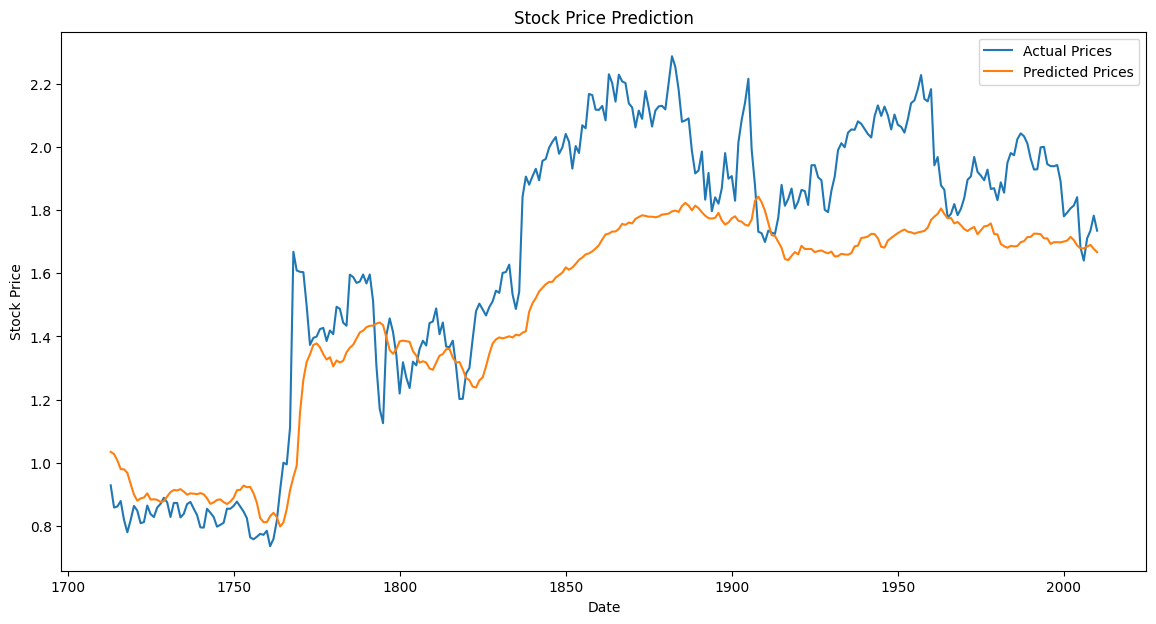

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Model with primary features with sentiment score

In [ ]:
features = df[['Open','High','Low','Volume','Daily_Sentiment', 'Close']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Volume','Daily_Sentiment', 'Close'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low    Volume  Daily_Sentiment     Close  \
0 -0.728923 -0.718036 -0.729263  1.250486         0.792021 -0.703025   
1 -0.714717 -0.716586 -0.727071  0.843785        -0.866150 -0.741715   
2 -0.731872 -0.734882 -0.757125  0.936631         0.145810 -0.744636   
3 -0.757188 -0.764489 -0.791023  1.276087        -0.129966 -0.764816   
4 -0.749742 -0.762831 -0.802973  0.985274         1.379527 -0.801121   

   tomorrow's closing value  
0                 -0.742463  
1                 -0.745383  
2                 -0.765550  
3                 -0.801832  
4                 -0.818305  


In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [ ]:
import numpy as np

# ----- Windowing Function -----
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])
    return np.array(X_seq), np.array(y_seq)

# ----- Set window size -----
window_size = 30  # You can change this to 10, 20, etc.

# ----- Apply windowing BEFORE train-test split -----
X_windowed, y_windowed = create_sequences(X, y, window_size)

# ----- Split into train, val, test -----
X_train, X_temp, y_train, y_temp = train_test_split(X_windowed, y_windowed, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# ----- LSTM Model (unchanged structure) -----
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))  # First LSTM layer
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# ----- Build the model -----
model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,051 (285.36 KB)

 Trainable params: 73,051 (285.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=35, batch_size=16, validation_data=(X_val, y_val), verbose=1)

Epoch 1/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1449 - val_loss: 0.0101
Epoch 2/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 3/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0107 - val_loss: 0.0080
Epoch 4/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0131 - val_loss: 0.0085
Epoch 5/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0108 - val_loss: 0.0083
Epoch 6/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0100 - val_loss: 0.0116
Epoch 7/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0092 - val_loss: 0.0103
Epoch 8/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 9/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 10/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0082 - val_loss: 0.0074
Epoch 11/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0090 - val_loss: 0.0070
Epoch 12/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0

In [ ]:
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 0.11701459968887007
Mean Squared Error (MSE): 0.022876617855790694
R-squared (R2): 0.8894467306522564


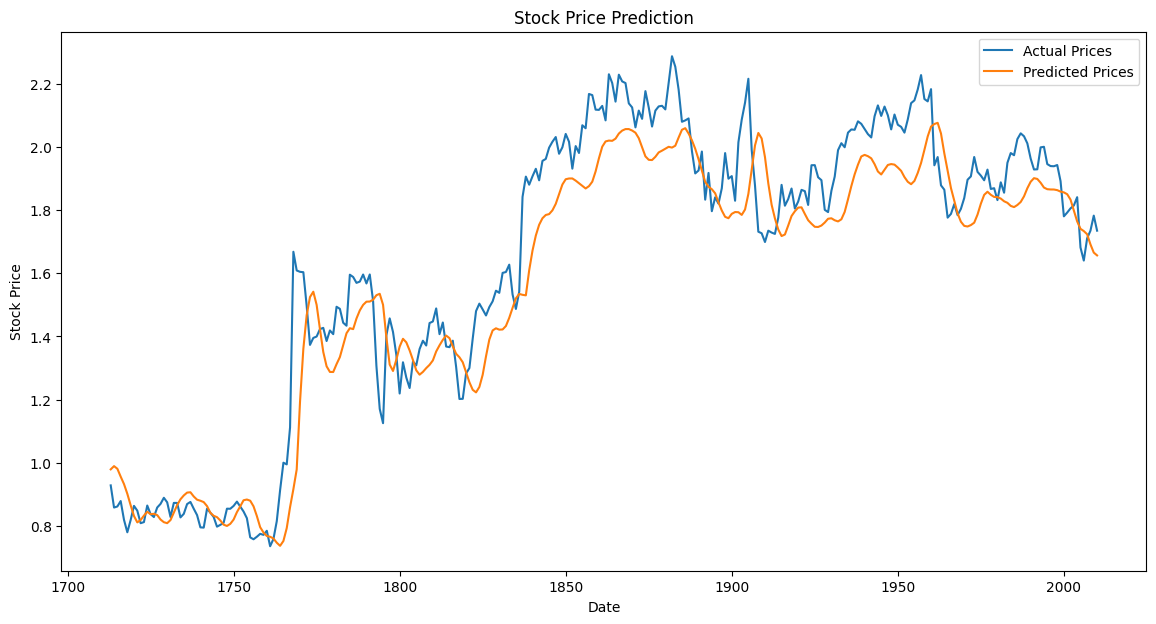

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Model run with external MA7, MA20, MACD, 20SD,	upper_band,	lower_band,	EMA

In [ ]:
features = df[['Open','High','Low','Volume','Daily_Sentiment', 'Close', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Volume','Daily_Sentiment', 'Close', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low    Volume  Daily_Sentiment     Close  \
0 -0.728923 -0.718036 -0.729263  1.250486         0.792021 -0.703025   
1 -0.714717 -0.716586 -0.727071  0.843785        -0.866150 -0.741715   
2 -0.731872 -0.734882 -0.757125  0.936631         0.145810 -0.744636   
3 -0.757188 -0.764489 -0.791023  1.276087        -0.129966 -0.764816   
4 -0.749742 -0.762831 -0.802973  0.985274         1.379527 -0.801121   

        MA7      MA20      MACD      20SD  upper_band  lower_band       EMA  \
0 -0.764148 -0.718854  0.284288 -0.489679   -0.731297   -0.701419 -0.736058   
1 -0.754301 -0.718673  0.331773 -0.488827   -0.731056   -0.701305 -0.721722   
2 -0.748954 -0.720363  0.350426 -0.499034   -0.733491   -0.702184 -0.728388   
3 -0.741735 -0.722205  0.385251 -0.485255   -0.734176   -0.705259 -0.747498   
4 -0.740673 -0.725585  0.546927 -0.512491   -0.739587   -0.706440 -0.748901   

   tomorrow's closing value  
0                 -0.74246

In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [ ]:
import numpy as np

# ----- Windowing Function -----
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])
    return np.array(X_seq), np.array(y_seq)

# ----- Set window size -----
window_size = 30  # You can change this to 10, 20, etc.

# ----- Apply windowing BEFORE train-test split -----
X_windowed, y_windowed = create_sequences(X, y, window_size)

# ----- Split into train, val, test -----
X_train, X_temp, y_train, y_temp = train_test_split(X_windowed, y_windowed, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# ----- LSTM Model (unchanged structure) -----
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))  # First LSTM layer
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# ----- Build the model -----
model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 100)        │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,851 (296.29 KB)

 Trainable params: 75,851 (296.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=35, batch_size=16, validation_data=(X_val, y_val), verbose=1)

Epoch 1/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1192 - val_loss: 0.0148
Epoch 2/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0121 - val_loss: 0.0168
Epoch 3/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0116 - val_loss: 0.0127
Epoch 4/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 5/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0090 - val_loss: 0.0100
Epoch 6/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0095 - val_loss: 0.0286
Epoch 7/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 8/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0095 - val_loss: 0.0189
Epoch 9/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 10/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 11/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0068 - val_loss: 0.0083
Epoch 12/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0

In [ ]:
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 0.18358792759909962
Mean Squared Error (MSE): 0.05294170668190767
R-squared (R2): 0.7441545426238498


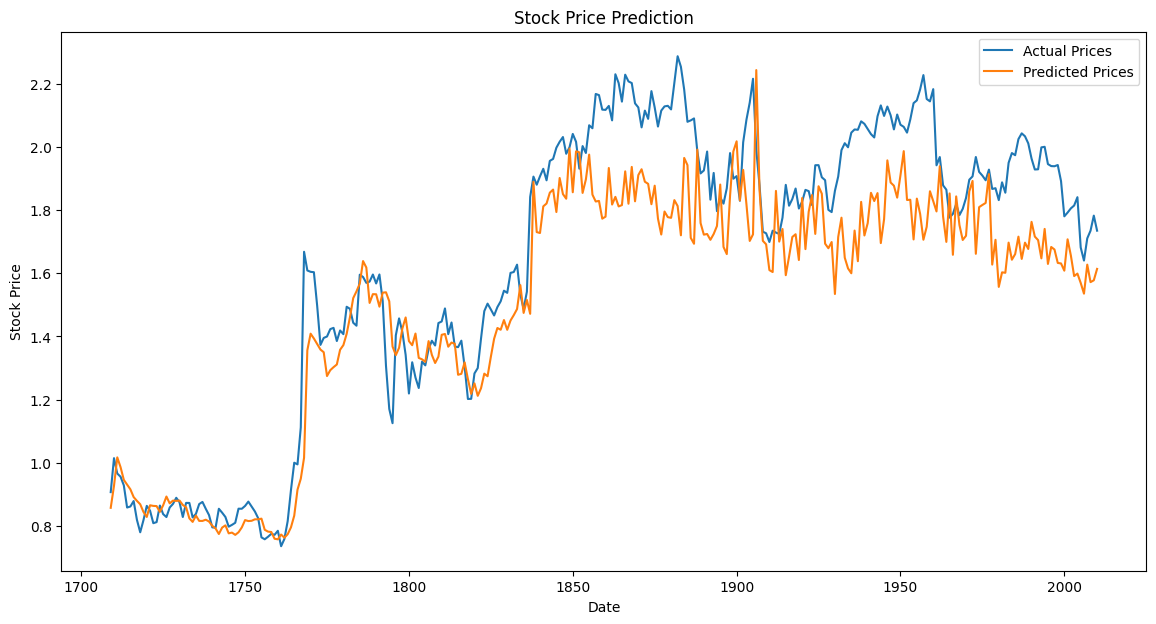

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Model run with all extracted features

In [ ]:
features = df[['Open','High','Low','Volume','Daily_Sentiment', 'Close', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'SMA_14',	'RSI_14',	'logmomentum']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Close', 'Volume','Daily_Sentiment', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'SMA_14',	'RSI_14',	'logmomentum'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low     Close    Volume  Daily_Sentiment  \
0 -0.728923 -0.718036 -0.729263  1.250486  0.792021        -0.703025   
1 -0.714717 -0.716586 -0.727071  0.843785 -0.866150        -0.741715   
2 -0.731872 -0.734882 -0.757125  0.936631  0.145810        -0.744636   
3 -0.757188 -0.764489 -0.791023  1.276087 -0.129966        -0.764816   
4 -0.749742 -0.762831 -0.802973  0.985274  1.379527        -0.801121   

        MA7      MA20      MACD      20SD  upper_band  lower_band       EMA  \
0 -0.764148 -0.718854  0.284288 -0.489679   -0.731297   -0.701419 -0.736058   
1 -0.754301 -0.718673  0.331773 -0.488827   -0.731056   -0.701305 -0.721722   
2 -0.748954 -0.720363  0.350426 -0.499034   -0.733491   -0.702184 -0.728388   
3 -0.741735 -0.722205  0.385251 -0.485255   -0.734176   -0.705259 -0.747498   
4 -0.740673 -0.725585  0.546927 -0.512491   -0.739587   -0.706440 -0.748901   

     SMA_14    RSI_14  logmomentum  tomorrow's closing v

In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler
import pandas as pd

joblib.dump(scaler, 'your_scaler.pkl')

print("Scaler saved as 'your_scaler.pkl'")

Scaler saved as 'your_scaler.pkl'


In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [ ]:
import numpy as np

# ----- Windowing Function -----
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])
    return np.array(X_seq), np.array(y_seq)

# ----- Set window size -----
window_size = 30  # You can change this to 10, 20, etc.

# ----- Apply windowing BEFORE train-test split -----
X_windowed, y_windowed = create_sequences(X, y, window_size)

# ----- Split into train, val, test -----
X_train, X_temp, y_train, y_temp = train_test_split(X_windowed, y_windowed, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# ----- LSTM Model (unchanged structure) -----
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))  # First LSTM layer
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# ----- Build the model -----
model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 100)        │        46,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,051 (300.98 KB)

 Trainable params: 77,051 (300.98 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=35, batch_size=16, validation_data=(X_val, y_val), verbose=1)

Epoch 1/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0639 - val_loss: 0.0281
Epoch 2/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0122 - val_loss: 0.0278
Epoch 3/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0098 - val_loss: 0.0202
Epoch 4/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0095 - val_loss: 0.0170
Epoch 5/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0090 - val_loss: 0.0174
Epoch 6/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0075 - val_loss: 0.0111
Epoch 7/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 8/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0079 - val_loss: 0.0176
Epoch 9/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0080 - val_loss: 0.0106
Epoch 10/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0086 - val_loss: 0.0109
Epoch 11/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0072 - val_loss: 0.0127
Epoch 12/35
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0

In [ ]:
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 0.15944501763640612
Mean Squared Error (MSE): 0.03516295040043707
R-squared (R2): 0.8300719472088893


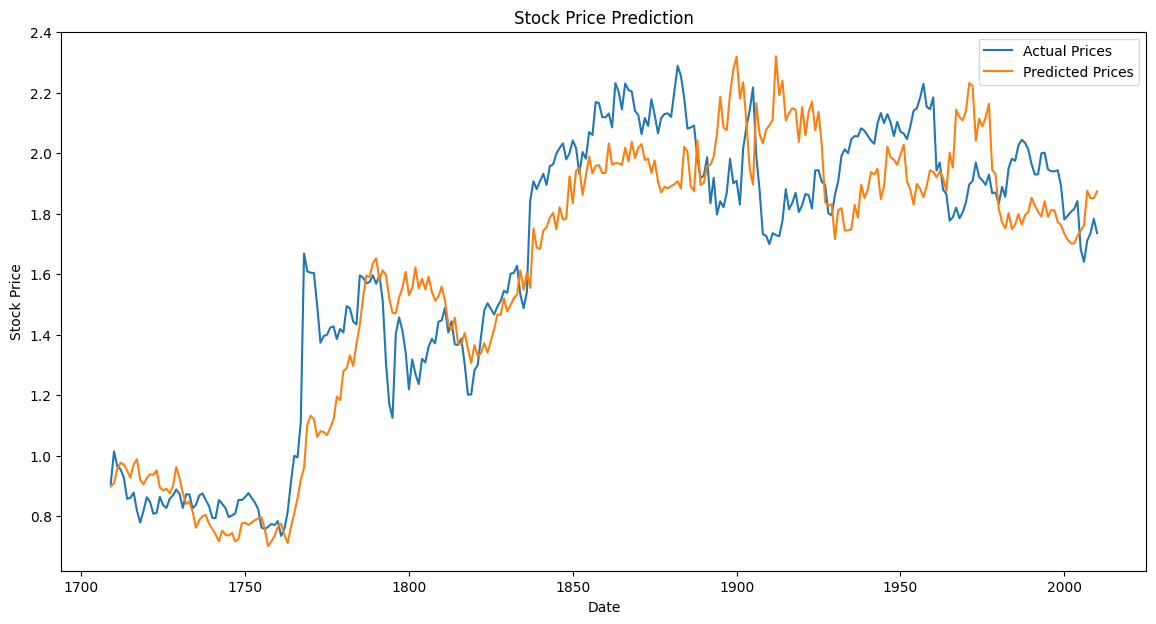

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Save the entire model to a local file
model.save('path_to_save_directory/trained_model.h5')  # Provide your desired directory and filename

# Random Forest

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
117 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
117 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Best Parameters: {'n_estimators': np.int64(110), 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


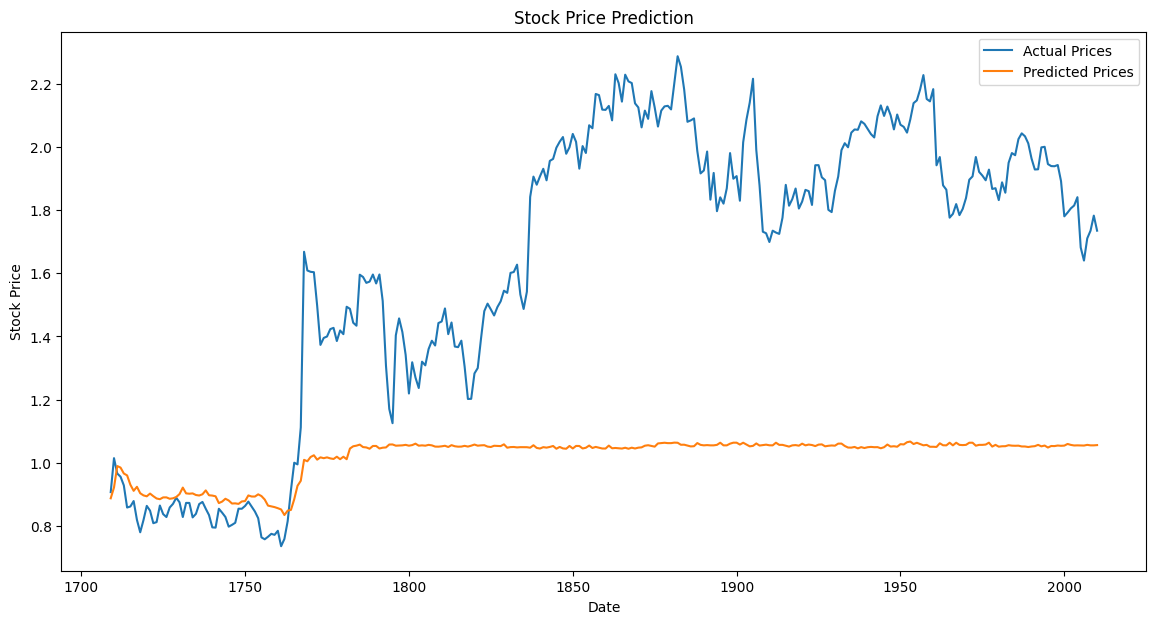

Tuned Random Forest - MAE: 0.631124603667435, MSE: 0.5379463355251942, R2: -1.5586106731114988


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(50, 200, 10),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Use RandomizedSearchCV for hyperparameter tuning
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf_random.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", rf_random.best_params_)

# Get the best estimator (Random Forest model)
best_rf_model = rf_random.best_estimator_

# Make predictions using the tuned model
y_pred_rf_tuned = best_rf_model.predict(X_test)

# Calculate metrics
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

# Plot Actual vs Predicted
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred_rf_tuned):], y_pred_rf_tuned, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print metrics
print(f"Tuned Random Forest - MAE: {mae_rf_tuned}, MSE: {mse_rf_tuned}, R2: {r2_rf_tuned}")


# Linear Regression model

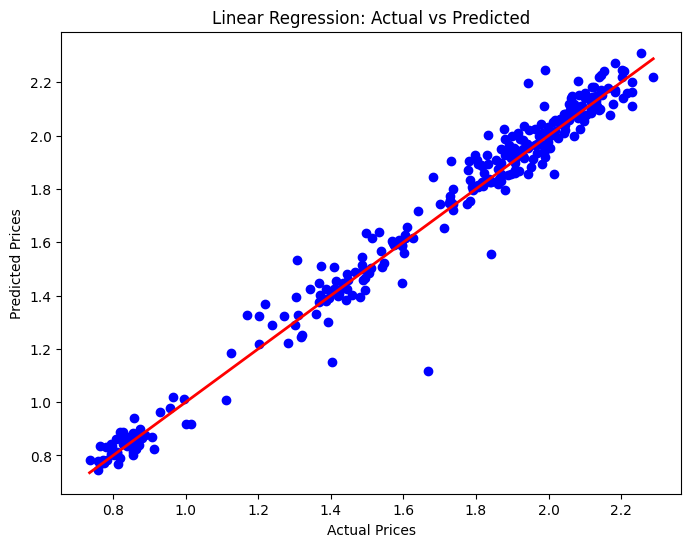

Linear Regression - MAE: 0.04793165238929389, MSE: 0.005155456640292655, R2: 0.9754793266288575


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Print metrics
print(f"Linear Regression - MAE: {mae_lr}, MSE: {mse_lr}, R2: {r2_lr}")


#  XGBoost Regressor

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [ ]:
features = df[['Open','High','Low','Volume','Daily_Sentiment', 'Close', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'SMA_14',	'RSI_14',	'logmomentum']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Close', 'Volume','Daily_Sentiment', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'SMA_14',	'RSI_14',	'logmomentum'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low     Close    Volume  Daily_Sentiment  \
0 -0.728923 -0.718036 -0.729263  1.250486  0.792021        -0.703025   
1 -0.714717 -0.716586 -0.727071  0.843785 -0.866150        -0.741715   
2 -0.731872 -0.734882 -0.757125  0.936631  0.145810        -0.744636   
3 -0.757188 -0.764489 -0.791023  1.276087 -0.129966        -0.764816   
4 -0.749742 -0.762831 -0.802973  0.985274  1.379527        -0.801121   

        MA7      MA20      MACD      20SD  upper_band  lower_band       EMA  \
0 -0.764148 -0.718854  0.284288 -0.489679   -0.731297   -0.701419 -0.736058   
1 -0.754301 -0.718673  0.331773 -0.488827   -0.731056   -0.701305 -0.721722   
2 -0.748954 -0.720363  0.350426 -0.499034   -0.733491   -0.702184 -0.728388   
3 -0.741735 -0.722205  0.385251 -0.485255   -0.734176   -0.705259 -0.747498   
4 -0.740673 -0.725585  0.546927 -0.512491   -0.739587   -0.706440 -0.748901   

     SMA_14    RSI_14  logmomentum  tomorrow's closing v

In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [ ]:


# Define the XGBoost model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 200, 10),              # Number of boosting rounds
    'max_depth': [3, 5, 7, 10],                          # Maximum depth of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],             # Learning rate (eta)
    'subsample': [0.6, 0.7, 0.8, 1.0],                    # Fraction of samples used for fitting
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],            # Fraction of features for each tree
    'gamma': [0, 0.1, 0.2, 0.3],                         # Minimum loss reduction required for a further partition
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_dist,
                                   n_iter=10, scoring='neg_mean_absolute_error',
                                   cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Train the final model with the best parameters
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': np.int64(160), 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Mean Absolute Error: 0.6322028917035782
Mean Squared Error: 0.5424591974235763
R2 Score: -1.5800750011623732


# Artificial Neural Network (ANN)

In [ ]:
features = df[['Open','High','Low','Volume','Daily_Sentiment', 'Close', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'SMA_14',	'RSI_14',	'logmomentum']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Close', 'Volume','Daily_Sentiment', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'SMA_14',	'RSI_14',	'logmomentum'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low     Close    Volume  Daily_Sentiment  \
0 -0.728923 -0.718036 -0.729263  1.250486  0.792021        -0.703025   
1 -0.714717 -0.716586 -0.727071  0.843785 -0.866150        -0.741715   
2 -0.731872 -0.734882 -0.757125  0.936631  0.145810        -0.744636   
3 -0.757188 -0.764489 -0.791023  1.276087 -0.129966        -0.764816   
4 -0.749742 -0.762831 -0.802973  0.985274  1.379527        -0.801121   

        MA7      MA20      MACD      20SD  upper_band  lower_band       EMA  \
0 -0.764148 -0.718854  0.284288 -0.489679   -0.731297   -0.701419 -0.736058   
1 -0.754301 -0.718673  0.331773 -0.488827   -0.731056   -0.701305 -0.721722   
2 -0.748954 -0.720363  0.350426 -0.499034   -0.733491   -0.702184 -0.728388   
3 -0.741735 -0.722205  0.385251 -0.485255   -0.734176   -0.705259 -0.747498   
4 -0.740673 -0.725585  0.546927 -0.512491   -0.739587   -0.706440 -0.748901   

     SMA_14    RSI_14  logmomentum  tomorrow's closing v

In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


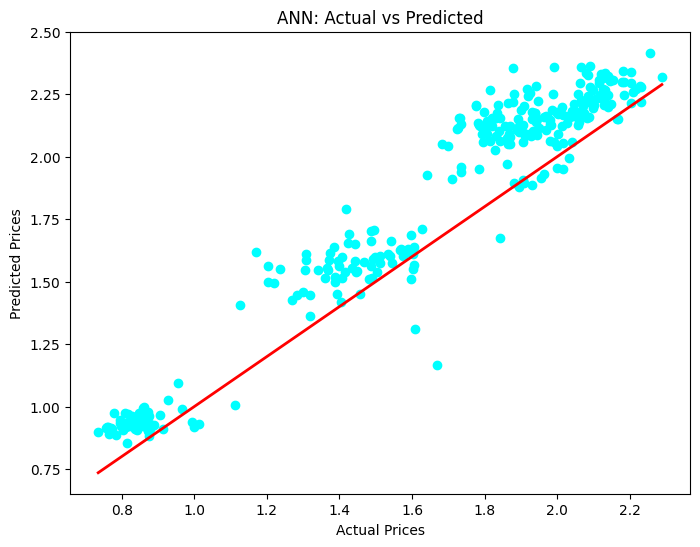

ANN - MAE: 0.16410407199344076, MSE: 0.038102510481859836, R2: 0.8187746926539599


In [ ]:
from sklearn.neural_network import MLPRegressor

# Initialize and train the model
ann_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
ann_model.fit(X_train, y_train)

# Make predictions
y_pred_ann = ann_model.predict(X_test)

# Calculate metrics
mae_ann = mean_absolute_error(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ann, color='cyan')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title('ANN: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Print metrics
print(f"ANN - MAE: {mae_ann}, MSE: {mse_ann}, R2: {r2_ann}")


# GRU model with original features



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
features = df[['Open','High','Low','Volume', 'Close']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Volume', 'Close'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low    Volume     Close  tomorrow's closing value
0 -0.728923 -0.718036 -0.729263  1.250486 -0.703025                 -0.742463
1 -0.714717 -0.716586 -0.727071  0.843785 -0.741715                 -0.745383
2 -0.731872 -0.734882 -0.757125  0.936631 -0.744636                 -0.765550
3 -0.757188 -0.764489 -0.791023  1.276087 -0.764816                 -0.801832
4 -0.749742 -0.762831 -0.802973  0.985274 -0.801121                 -0.818305


In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


Shape of X_train_seq before reshaping: (1357, 50, 5)
Shape of y_train_seq before reshaping: (1357, 1)
Shape of X_test_seq before reshaping: (252, 50, 5)
Shape of y_test_seq before reshaping: (252, 1)
Shape of X_train_reshaped: (1357, 50, 5)
Shape of X_test_reshaped: (252, 50, 5)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 140ms/step - loss: 2.3364 - mae: 0.2487 - val_loss: 1.3662 - val_mae: 0.1810
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 1.1397 - mae: 0.1076 - val_loss: 0.7082 - val_mae: 0.1781
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.5839 - mae: 0.0985 - val_loss: 0.4037 - val_mae: 0.1935
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.3217 - mae: 0.0903 - val_loss: 0.2335 - val_mae: 0.1355
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.1948 - mae: 0.0835 - val_loss: 0.1871 - val_mae: 0.2059
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.1287 - mae: 0.0784 - val_loss: 0.1464 - val_mae: 0.2082
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.0928 - mae: 0.0821 - val_loss: 0.0947 - val_mae: 0.1429
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.0681 - mae: 0.0765 - val_loss: 0.0835 - val_mae: 0.1585
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.05

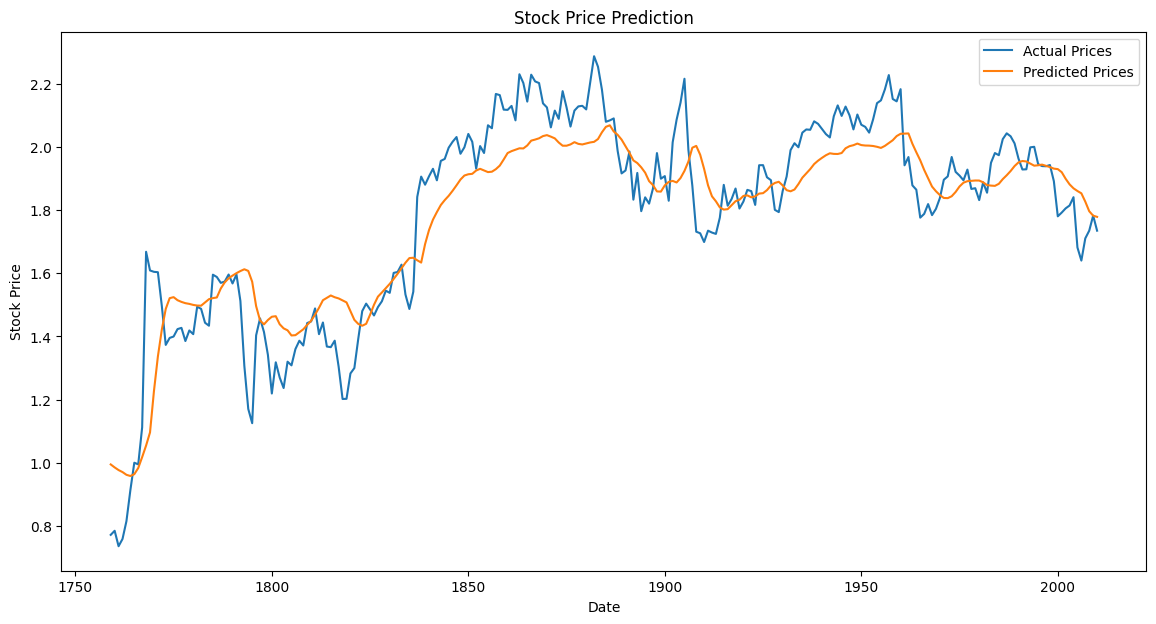

GRU Model - MAE: 0.10699988692623581, MSE: 0.019304051706124422, R2: 0.8165786875542823


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import GRU, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.regularizers import l2  # Import the regularizer

# Windowing function to create sequences of data
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])  # Create input window
        y_seq.append(y[i + window_size])    # Corresponding output value
    return np.array(X_seq), np.array(y_seq)

# Define the GRU model with regularization and other anti-overfitting techniques
def create_gru_model(input_shape, units=50, dropout_rate=0.3, learning_rate=0.001, batch_size=32, epochs=100):
    model = Sequential()

    # Adding Bidirectional GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=True, input_shape=input_shape,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Adding another GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=False,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Fully connected output layer
    model.add(Dense(units=1))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Assuming you already have X_train, X_test, y_train, y_test data prepared

# Parameters for windowing
window_size = 50  # Adjust as needed, based on the time series nature of your data

# Apply windowing to the training and test data
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

# Check the shapes of the sequences
print("Shape of X_train_seq before reshaping:", X_train_seq.shape)
print("Shape of y_train_seq before reshaping:", y_train_seq.shape)
print("Shape of X_test_seq before reshaping:", X_test_seq.shape)
print("Shape of y_test_seq before reshaping:", y_test_seq.shape)

# Reshape the data to match GRU input requirements (assuming 1 feature per timestep)
# Reshape to (samples, time_steps, 1)
X_train_reshaped = np.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1], 5))
X_test_reshaped = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1], 5))

# Check the reshaped data shapes
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

# Create the GRU model
gru_model = create_gru_model(input_shape=(X_train_reshaped.shape[1], 1), units=50, dropout_rate=0.3, learning_rate=0.001)

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = gru_model.fit(X_train_reshaped, y_train_seq, epochs=50, batch_size=32,
                        validation_data=(X_test_reshaped, y_test_seq), callbacks=[early_stopping])

# Make predictions
y_pred_gru = gru_model.predict(X_test_reshaped)

# Evaluate the model
mae_gru = mean_absolute_error(y_test_seq, y_pred_gru)
mse_gru = mean_squared_error(y_test_seq, y_pred_gru)
r2_gru = r2_score(y_test_seq, y_pred_gru)

# Plot Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_seq):], y_test_seq, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred_gru):], y_pred_gru, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print metrics
print(f"GRU Model - MAE: {mae_gru}, MSE: {mse_gru}, R2: {r2_gru}")


# Gru model with the feature of sentiment score

In [ ]:
features = df[['Open','High','Low','Volume','Daily_Sentiment', 'Close']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Volume','Daily_Sentiment', 'Close'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low    Volume  Daily_Sentiment     Close  \
0 -0.728923 -0.718036 -0.729263  1.250486         0.792021 -0.703025   
1 -0.714717 -0.716586 -0.727071  0.843785        -0.866150 -0.741715   
2 -0.731872 -0.734882 -0.757125  0.936631         0.145810 -0.744636   
3 -0.757188 -0.764489 -0.791023  1.276087        -0.129966 -0.764816   
4 -0.749742 -0.762831 -0.802973  0.985274         1.379527 -0.801121   

   tomorrow's closing value  
0                 -0.742463  
1                 -0.745383  
2                 -0.765550  
3                 -0.801832  
4                 -0.818305  


In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


Shape of X_train_seq before reshaping: (1357, 50, 6)
Shape of y_train_seq before reshaping: (1357, 1)
Shape of X_test_seq before reshaping: (252, 50, 6)
Shape of y_test_seq before reshaping: (252, 1)
Shape of X_train_reshaped: (1357, 50, 6)
Shape of X_test_reshaped: (252, 50, 6)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - loss: 2.5015 - mae: 0.3210 - val_loss: 1.5185 - val_mae: 0.2611
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 1.2604 - mae: 0.1213 - val_loss: 0.8219 - val_mae: 0.1801
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.6945 - mae: 0.0980 - val_loss: 0.4898 - val_mae: 0.1653
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.4180 - mae: 0.0990 - val_loss: 0.3184 - val_mae: 0.1499
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.2714 - mae: 0.0878 - val_loss: 0.2270 - val_mae: 0.1470
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.1897 - mae: 0.0810 - val_loss: 0.1737 - val_mae: 0.1497
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.1412 - mae: 0.0813 - val_loss: 0.1292 - val_mae: 0.1253
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.1073 - mae: 0.0766 - val_loss: 0.0993 - val_mae: 0.1096
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.083

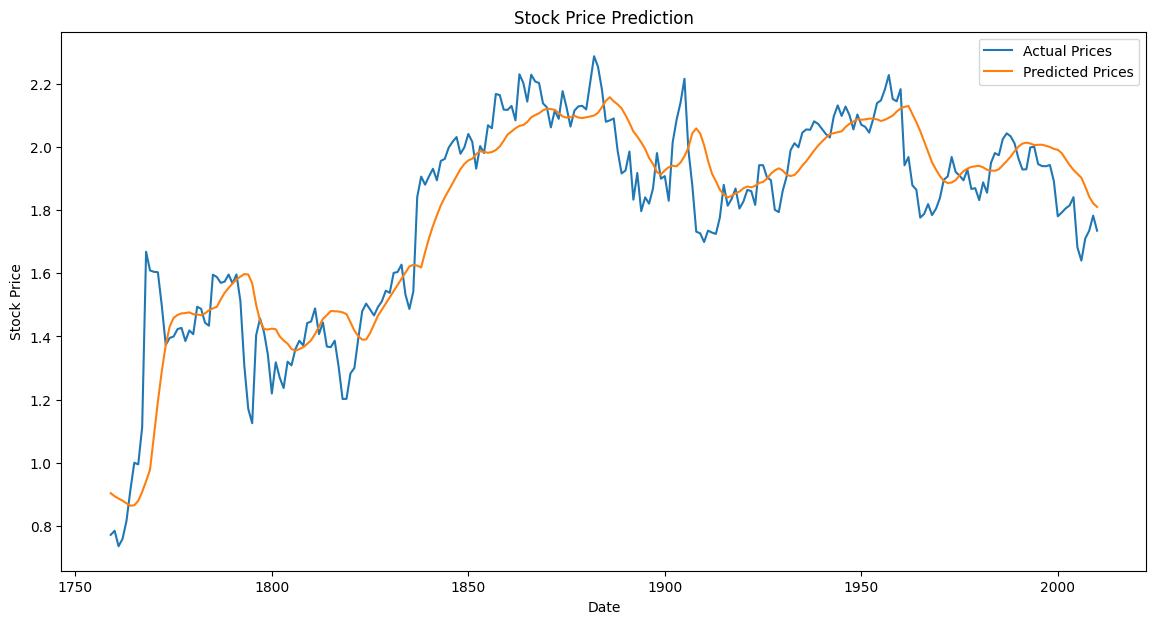

GRU Model - MAE: 0.10025175886841373, MSE: 0.01971852415490384, R2: 0.812640494594325


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import GRU, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.regularizers import l2  # Import the regularizer

# Windowing function to create sequences of data
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])  # Create input window
        y_seq.append(y[i + window_size])    # Corresponding output value
    return np.array(X_seq), np.array(y_seq)

# Define the GRU model with regularization and other anti-overfitting techniques
def create_gru_model(input_shape, units=50, dropout_rate=0.3, learning_rate=0.001, batch_size=32, epochs=100):
    model = Sequential()

    # Adding Bidirectional GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=True, input_shape=input_shape,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Adding another GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=False,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Fully connected output layer
    model.add(Dense(units=1))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Assuming you already have X_train, X_test, y_train, y_test data prepared

# Parameters for windowing
window_size = 50  # Adjust as needed, based on the time series nature of your data

# Apply windowing to the training and test data
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

# Check the shapes of the sequences
print("Shape of X_train_seq before reshaping:", X_train_seq.shape)
print("Shape of y_train_seq before reshaping:", y_train_seq.shape)
print("Shape of X_test_seq before reshaping:", X_test_seq.shape)
print("Shape of y_test_seq before reshaping:", y_test_seq.shape)

# Reshape the data to match GRU input requirements (assuming 1 feature per timestep)
# Reshape to (samples, time_steps, 1)
X_train_reshaped = np.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1], 6))
X_test_reshaped = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1], 6))

# Check the reshaped data shapes
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

# Create the GRU model
gru_model = create_gru_model(input_shape=(X_train_reshaped.shape[1], 1), units=50, dropout_rate=0.3, learning_rate=0.001)

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = gru_model.fit(X_train_reshaped, y_train_seq, epochs=50, batch_size=32,
                        validation_data=(X_test_reshaped, y_test_seq), callbacks=[early_stopping])

# Make predictions
y_pred_gru = gru_model.predict(X_test_reshaped)

# Evaluate the model
mae_gru = mean_absolute_error(y_test_seq, y_pred_gru)
mse_gru = mean_squared_error(y_test_seq, y_pred_gru)
r2_gru = r2_score(y_test_seq, y_pred_gru)

# Plot Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_seq):], y_test_seq, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred_gru):], y_pred_gru, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print metrics
print(f"GRU Model - MAE: {mae_gru}, MSE: {mse_gru}, R2: {r2_gru}")


In [ ]:
print("Shape of X_train_seq before reshaping:", X_train_seq.shape)
print("Shape of X_test_seq before reshaping:", X_test_seq.shape)


Shape of X_train_seq before reshaping: (1357, 50, 6)
Shape of X_test_seq before reshaping: (252, 50, 6)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 2.2568 - mae: 0.3069 - val_loss: 1.3246 - val_mae: 0.3817
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.9768 - mae: 0.0979 - val_loss: 0.5590 - val_mae: 0.2083
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.4249 - mae: 0.0773 - val_loss: 0.2812 - val_mae: 0.2283
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1887 - mae: 0.0751 - val_loss: 0.2112 - val_mae: 0.3086
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0903 - mae: 0.0670 - val_loss: 0.1300 - val_mae: 0.2505
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0509 - mae: 0.0692 - val_loss: 0.1111 - val_mae: 0.2525
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0328 - mae: 0.0648 - val_loss: 0.1432 - val_mae: 0.3173
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0253 - mae: 0.0658 - val_loss: 0.1283 - val_mae: 0.3030
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0192 - mae: 0

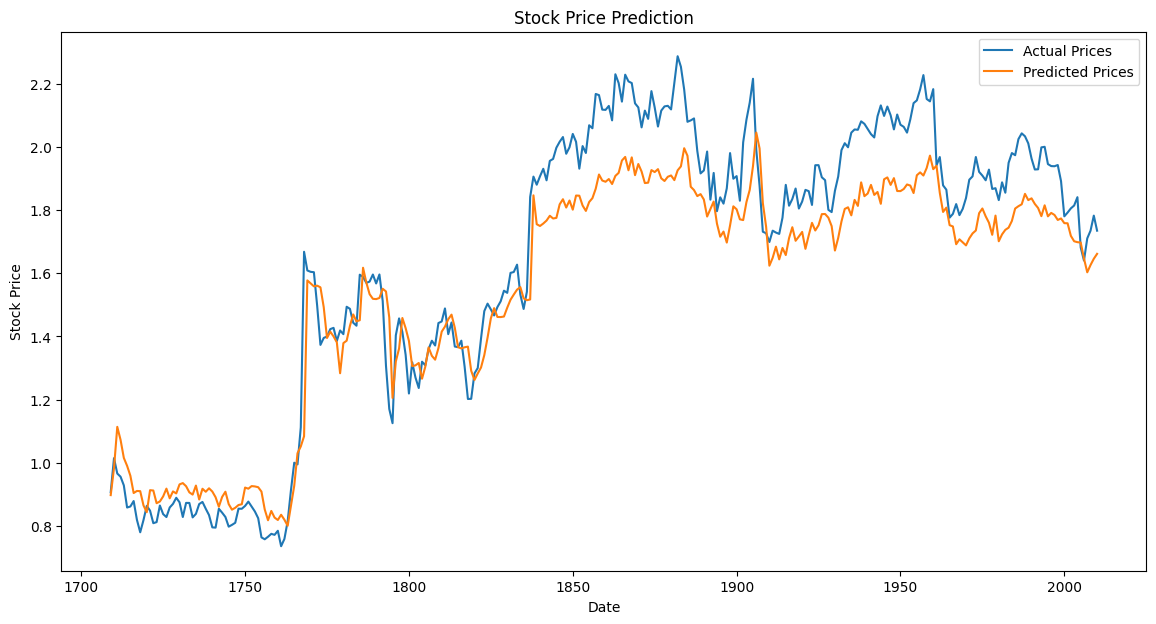

GRU Model - MAE: 0.12469040640034793, MSE: 0.023032544748905436, R2: 0.890451312832286


In [ ]:


# Define the GRU model with regularization and other anti-overfitting techniques
def create_gru_model(input_shape, units=50, dropout_rate=0.3, learning_rate=0.001, batch_size=32, epochs=100):
    model = Sequential()

    # Adding Bidirectional GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=True, input_shape=input_shape,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Adding another GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=False,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Fully connected output layer
    model.add(Dense(units=1))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Prepare the input data for GRU (assuming X_train, X_test, y_train, y_test are already defined)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Assuming 1 feature per timestep
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create the GRU model
gru_model = create_gru_model(input_shape=(X_train_reshaped.shape[1], 1), units=50, dropout_rate=0.3, learning_rate=0.001)

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = gru_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32,
                        validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# Make predictions
y_pred_gru = gru_model.predict(X_test_reshaped)

# Evaluate the model
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

# Plot Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred_gru):], y_pred_gru, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print metrics
print(f"GRU Model - MAE: {mae_gru}, MSE: {mse_gru}, R2: {r2_gru}")


# GPU model with all features

In [ ]:
features = df[['Open','High','Low','Volume','Daily_Sentiment', 'Close', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'SMA_14',	'RSI_14',	'logmomentum']].values
target = df["tomorrow's closing value"].values

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, columns=['Open','High','Low','Volume','Daily_Sentiment', 'Close', 'MA7',	'MA20',	'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'SMA_14',	'RSI_14',	'logmomentum'])
scaled_target_df = pd.DataFrame(scaled_target, columns=["tomorrow's closing value"])

# Preview of the scaled data (features and target)
print("\nScaled Data (Features and Target):")
scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())


Scaled Data (Features and Target):
       Open      High       Low    Volume  Daily_Sentiment     Close  \
0 -0.728923 -0.718036 -0.729263  1.250486         0.792021 -0.703025   
1 -0.714717 -0.716586 -0.727071  0.843785        -0.866150 -0.741715   
2 -0.731872 -0.734882 -0.757125  0.936631         0.145810 -0.744636   
3 -0.757188 -0.764489 -0.791023  1.276087        -0.129966 -0.764816   
4 -0.749742 -0.762831 -0.802973  0.985274         1.379527 -0.801121   

        MA7      MA20      MACD      20SD  upper_band  lower_band       EMA  \
0 -0.764148 -0.718854  0.284288 -0.489679   -0.731297   -0.701419 -0.736058   
1 -0.754301 -0.718673  0.331773 -0.488827   -0.731056   -0.701305 -0.721722   
2 -0.748954 -0.720363  0.350426 -0.499034   -0.733491   -0.702184 -0.728388   
3 -0.741735 -0.722205  0.385251 -0.485255   -0.734176   -0.705259 -0.747498   
4 -0.740673 -0.725585  0.546927 -0.512491   -0.739587   -0.706440 -0.748901   

     SMA_14    RSI_14  logmomentum  tomorrow's closing v

In [ ]:
X = scaled_features
y = scaled_target

In [ ]:
#Train Val Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import GRU, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Windowing function to create sequences of data
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])  # Create input window
        y_seq.append(y[i + window_size])    # Corresponding output value
    return np.array(X_seq), np.array(y_seq)

# Define the GRU model with regularization and other anti-overfitting techniques
def create_gru_model(input_shape, units=50, dropout_rate=0.3, learning_rate=0.001, batch_size=32, epochs=100):
    model = Sequential()

    # Adding Bidirectional GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=True, input_shape=input_shape,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Adding another GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=False,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Fully connected output layer
    model.add(Dense(units=1))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Assuming you already have X_train, X_test, y_train, y_test data prepared

# Parameters for windowing
window_size = 14  # Adjust as needed, based on the time series nature of your data

# Apply windowing to the training and test data
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

# Reshape the data to match GRU input requirements
X_train_reshaped = np.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1],1))
X_test_reshaped = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1],1))

# Create the GRU model
gru_model = create_gru_model(input_shape=(X_train_reshaped.shape[1], 1), units=50, dropout_rate=0.3, learning_rate=0.001)

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = gru_model.fit(X_train_reshaped, y_train_seq, epochs=50, batch_size=32,
                        validation_data=(X_test_reshaped, y_test_seq), callbacks=[early_stopping])

# Make predictions
y_pred_gru = gru_model.predict(X_test_reshaped)

# Evaluate the model
mae_gru = mean_absolute_error(y_test_seq, y_pred_gru)
mse_gru = mean_squared_error(y_test_seq, y_pred_gru)
r2_gru = r2_score(y_test_seq, y_pred_gru)

# Plot Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_seq):], y_test_seq, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred_gru):], y_pred_gru, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print metrics
print(f"GRU Model - MAE: {mae_gru}, MSE: {mse_gru}, R2: {r2_gru}")


ValueError: cannot reshape array of size 312032 into shape (1393,14,1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 2.2346 - mae: 0.2928 - val_loss: 1.2592 - val_mae: 0.2985
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.9751 - mae: 0.1159 - val_loss: 0.6039 - val_mae: 0.2839
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4334 - mae: 0.1001 - val_loss: 0.2837 - val_mae: 0.2138
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.2002 - mae: 0.0927 - val_loss: 0.1785 - val_mae: 0.2361
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1017 - mae: 0.0854 - val_loss: 0.0804 - val_mae: 0.1291
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0601 - mae: 0.0838 - val_loss: 0.0537 - val_mae: 0.1100
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0411 - mae: 0.0805 - val_loss: 0.0436 - val_mae: 0.1107
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0311 - mae: 0.0773 - val_loss: 0.0374 - val_mae: 0.1119
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0248 - mae: 0

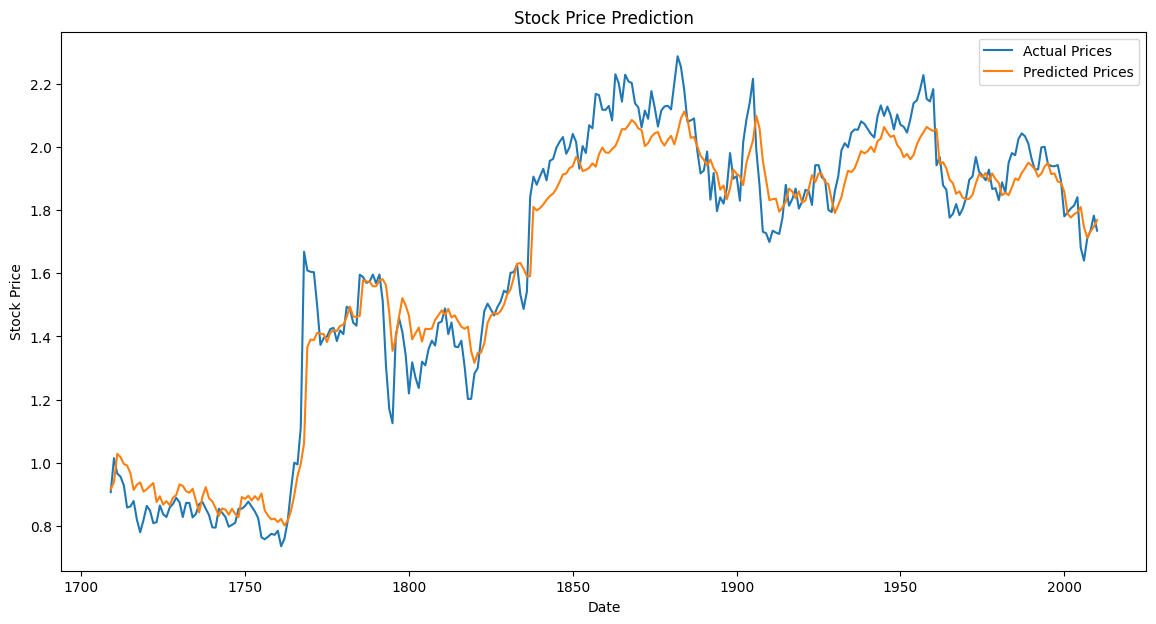

GRU Model - MAE: 0.07689615908359118, MSE: 0.010184127514983926, R2: 0.9515616788601658


In [ ]:


# Define the GRU model with regularization and other anti-overfitting techniques
def create_gru_model(input_shape, units=50, dropout_rate=0.3, learning_rate=0.001, batch_size=32, epochs=100):
    model = Sequential()

    # Adding Bidirectional GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=True, input_shape=input_shape,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Adding another GRU Layer with L2 regularization
    model.add(Bidirectional(GRU(units=units, return_sequences=False,
                                 kernel_regularizer=l2(0.01))))
    model.add(Dropout(dropout_rate))

    # Fully connected output layer
    model.add(Dense(units=1))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Prepare the input data for GRU (assuming X_train, X_test, y_train, y_test are already defined)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Assuming 1 feature per timestep
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create the GRU model
gru_model = create_gru_model(input_shape=(X_train_reshaped.shape[1], 1), units=50, dropout_rate=0.3, learning_rate=0.001)

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = gru_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32,
                        validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# Make predictions
y_pred_gru = gru_model.predict(X_test_reshaped)

# Evaluate the model
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

# Plot Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred_gru):], y_pred_gru, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print metrics
print(f"GRU Model - MAE: {mae_gru}, MSE: {mse_gru}, R2: {r2_gru}")


# Transformer Model

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.2143 - mae: 0.3576 - val_loss: 0.0828 - val_mae: 0.2444
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1000 - mae: 0.2662 - val_loss: 0.0813 - val_mae: 0.2440
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0897 - mae: 0.2554 - val_loss: 0.0875 - val_mae: 0.2570
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0905 - mae: 0.2538 - val_loss: 0.0816 - val_mae: 0.2447
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0822 - mae: 0.2448 - val_loss: 0.0824 - val_mae: 0.2434
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0851 - mae: 0.2501 - val_loss: 0.0860 - val_mae: 0.2543
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0847 - mae: 0.2472 - val_loss: 0.0843 - val_mae: 0.2518
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0884 - mae: 0.2614 - val_loss: 0.0823 - val_mae: 0.2471
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0857 - mae:

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Mean Absolute Error (MAE): 0.2524862558470983
Mean Squared Error (MSE): 0.08675131334132566
R2 Score: -0.08440578745465177


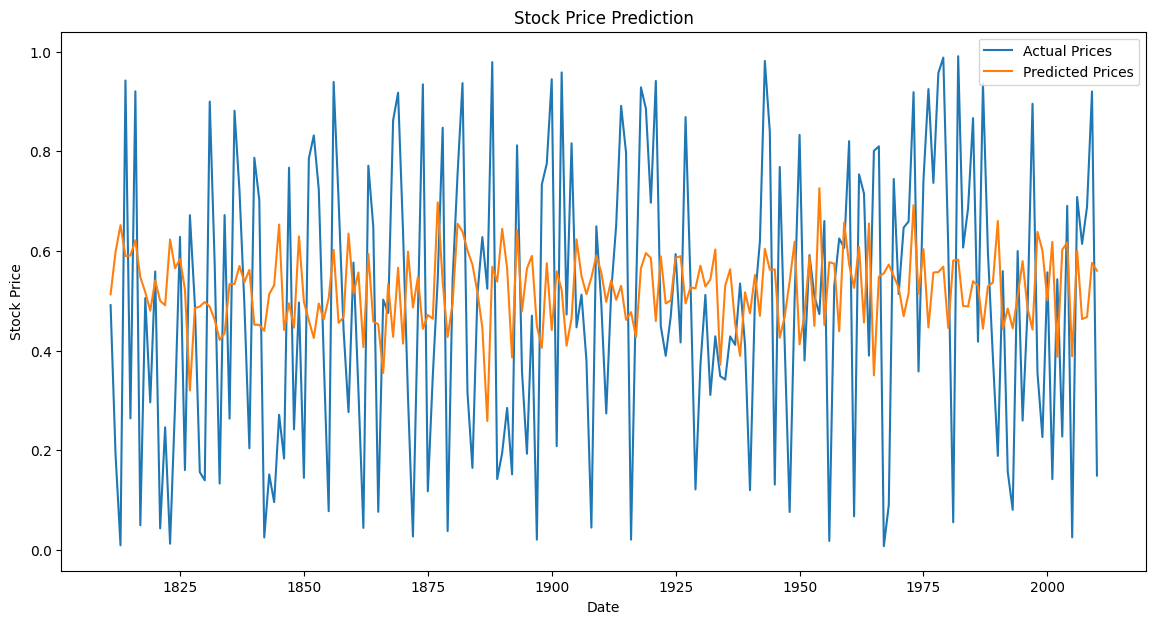

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define Transformer Model
def build_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)  # Regression output

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (1, number of features)
model = build_transformer_model(input_shape)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Model Evaluation
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R2 Score: {r2}')

# Plot Actual vs Predicted
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')  # Use the Date index for X-axis
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Save the model if required
# model.save('stock_price_transformer_model.h5')
